# Training

In [1]:
# Import all packages

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import sys
%matplotlib inline

In [2]:
# chdir. it depends on the platform
if sys.platform == 'linux':
    # if os is linux cd to
    project_path = "/home/mate/develop/PycharmProjects/GeFace/"
    NUMBER_OF_DATA = 100000
elif sys.platform is 'windows':
    pass
else:
    pass

os.chdir(project_path)

In [3]:
try:
    print(os.getcwd())
    # Open CSV with all informations
    csv_file = pd.read_csv("faces_colored/faces_correct.csv",delimiter = ',', encoding = "ISO-8859-1", engine='python')
    pd.set_option('display.max_columns', 100)
except (FileNotFoundError):
    print("CSV file not found")
    current_path = os.getcwd()
    print("Current path is " + current_path)

/home/mate/develop/PycharmProjects/GeFace


In [4]:
csv_file.head()

,nr,age,full_path,gender
0,0,69,01/nm0000001_rm124825600_1899-5-10_1968.jpg,1.0
1,1,71,01/nm0000001_rm3343756032_1899-5-10_1970.jpg,1.0
2,2,69,01/nm0000001_rm577153792_1899-5-10_1968.jpg,1.0
3,5,67,02/nm0000002_rm1075631616_1924-9-16_1991.jpg,0.0
4,6,80,02/nm0000002_rm1346607872_1924-9-16_2004.jpg,0.0


In [5]:
#df = csv_file.drop(columns=["nr"])
df = csv_file 

In [6]:
# convert 1.0 to m as male
#         0.0 to f as female
def mod(x):
    if x == 1.0:
        x = "m"
    else:
        x = "f"
    return x

df["gender"] = df["gender"].apply(mod)

In [7]:
df.head()

,nr,age,full_path,gender
0,0,69,01/nm0000001_rm124825600_1899-5-10_1968.jpg,m
1,1,71,01/nm0000001_rm3343756032_1899-5-10_1970.jpg,m
2,2,69,01/nm0000001_rm577153792_1899-5-10_1968.jpg,m
3,5,67,02/nm0000002_rm1075631616_1924-9-16_1991.jpg,f
4,6,80,02/nm0000002_rm1346607872_1924-9-16_2004.jpg,f


In [8]:
# create dataset for testing the network
import random
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# proba_df = df.head()
proba_df = df.head(100)
# Randomize but always the same random numbers
np.random.seed(42)
random.seed(42)
# shuffle rows
proba_df = shuffle(proba_df)

In [9]:
proba_df.head()

,nr,age,full_path,gender
83,131,40,08/nm0000008_rm3248131584_1924-4-3_1964.jpg,m
53,72,29,04/nm0000004_rm1520029184_1949-1-24_1978.jpg,m
70,106,48,08/nm0000008_rm1560581632_1924-4-3_1972.jpg,m
45,62,31,03/nm0000003_rm3328162560_1934-9-28_1965.jpg,f
44,59,31,03/nm0000003_rm3277830912_1934-9-28_1965.jpg,f


In [10]:
proba_df.shape

(100, 4)

In [11]:
# calculate test train valid data numbers
test_num = int(np.floor(0.1 * proba_df.shape[0]))
valid_num = int(np.floor(0.2 * proba_df.shape[0]))
train_num = int(proba_df.shape[0] - test_num - valid_num)
print("train: {} | valid: {} | test: {}".format(train_num, valid_num, test_num))

train: 70 | valid: 20 | test: 10


In [12]:
# split the data into train valid and test data
train_data = proba_df.iloc[0:train_num, :]

valid_data = proba_df.iloc[train_num:train_num + valid_num, :]

test_data = proba_df.iloc[ train_num+valid_num:, :]

print("train: {} | valid: {} | test: {}".format(train_data.shape, valid_data.shape, test_data.shape))

train: (70, 4) | valid: (20, 4) | test: (10, 4)


In [13]:
image_path = "faces_colored/"
x_train_p = image_path + train_data['full_path'].values
x_valid_p = image_path + valid_data['full_path'].values
x_test_p = image_path + test_data['full_path'].values


x_test_p.shape
x_test_p[0]

'faces_colored/08/nm0000008_rm3930489088_1924-4-3_1972.jpg'

In [14]:
# get the ages
y_train_age = train_data['age'].values
y_valid_age = valid_data['age'].values
y_test_age = test_data['age'].values

print("age:" ,len(y_train_age), " | ", len(y_valid_age))
#y_train_age


age: 70  |  20


In [15]:
y_train_gender = train_data['gender'].values
y_valid_gender = valid_data['gender'].values
y_test_gender = test_data['gender'].values
print("gender:", len(y_train_gender), " | ", len(y_valid_gender))

# convert to string
y_train_age = y_train_age.astype("float32")
y_valid_age = y_valid_age.astype("float32")
y_test_age = y_test_age.astype("float32")

gender: 70  |  20


In [16]:
test_data = pd.DataFrame({"x_test_path": x_test_p, "y_test_age": y_test_age, "y_test_gender": y_test_gender})
test_data.to_csv( project_path+"test_data.csv", sep=",")

# Copy train, valid, test data into a new folder

In [17]:
proba_df.head()

,nr,age,full_path,gender
83,131,40,08/nm0000008_rm3248131584_1924-4-3_1964.jpg,m
53,72,29,04/nm0000004_rm1520029184_1949-1-24_1978.jpg,m
70,106,48,08/nm0000008_rm1560581632_1924-4-3_1972.jpg,m
45,62,31,03/nm0000003_rm3328162560_1934-9-28_1965.jpg,f
44,59,31,03/nm0000003_rm3277830912_1934-9-28_1965.jpg,f


# Training and model building

In [18]:
# import the necessary packages
import sys
import os
import PIL
# import the necessary packages
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
import tensorflow as tf
from keras.optimizers import *
from keras.applications import Xception
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model
 
# import the necessary packages
#from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
# from pyimagesearch.smallervggnet import SmallerVGGNet
# from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os

Using TensorFlow backend.


In [19]:
agesBranch = None
genderBranch = None
class FaceNet:
    
    @staticmethod
    def build_ages_branch(inputs, numAges, finalAct="sigmoid", chanDim=-1):
        # utilize a lambda layer to convert the 3 channel input to a
        # grayscale representation
        x = Conv2D(32, (3, 3), padding="same")(inputs) 
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        x = Flatten()(x)
        predictions = Dense(1, activation=finalAct,name="ages_output")(x)
        # add your top layer block to your base model

        #print(model.summary())
    
        # define a branch of output layers for the number of different
        # ages
        # return the category prediction sub-network
        return predictions
    

    
    @staticmethod
    def build_gender_branch(inputs, numGender, finalAct="softmax", chanDim=-1):
       
        padding = "same"
        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding=padding, trainable=False)(inputs) 
        x = Activation("relu",trainable=False)(x)
        x = BatchNormalization(axis=chanDim,trainable=False)(x)
        x = MaxPooling2D(pool_size=(3, 3),trainable=False)(x)
        x = Dropout(0.25,trainable=False)(x)
        
        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding=padding, trainable=False)(x) 
        x = Activation("relu", trainable=False)(x)
        x = BatchNormalization(axis=chanDim,trainable=False)(x)
        x = MaxPooling2D(pool_size=(3, 3),trainable=False)(x)
        x = Dropout(0.25,trainable=False)(x)
        
        # (CONV => RELU) * 2 => POOL
        x = Conv2D(64, (5, 5), padding=padding,trainable=False)(x)
        x = Activation("relu",trainable=False)(x)
        x = BatchNormalization(axis=chanDim,trainable=False)(x)
        x = Conv2D(64, (3, 3), padding=padding,trainable=False)(x)
        x = Activation("relu",trainable=False)(x)
        x = BatchNormalization(axis=chanDim,trainable=False)(x)
        x = MaxPooling2D(pool_size=(2, 2),trainable=False)(x)
        x = Dropout(0.25,trainable=False)(x)
        
        
        # (CONV => RELU) * 2 => POOL
        x = Conv2D(64, (5, 5), padding=padding,trainable=False)(x)
        x = Activation("relu",trainable=False)(x)
        x = BatchNormalization(axis=chanDim,trainable=False)(x)
        x = Conv2D(64, (3, 3), padding=padding,trainable=False)(x)
        x = Activation("relu",trainable=False)(x)
        x = BatchNormalization(axis=chanDim,trainable=False)(x)
        x = MaxPooling2D(pool_size=(2, 2),trainable=False)(x)
        x = Dropout(0.25,trainable=False)(x)
 
        # (CONV => RELU) * 2 => POOL
        x = Conv2D(128, (3, 3), padding=padding,trainable=False)(x)
        x = Activation("relu",trainable=False)(x)
        x = BatchNormalization(axis=chanDim,trainable=False)(x)
        x = Conv2D(128, (3, 3), padding=padding,trainable=False)(x)
        x = Activation("relu",trainable=False)(x)
        x = BatchNormalization(axis=chanDim,trainable=False)(x)
        x = MaxPooling2D(pool_size=(2, 2),trainable=False)(x)
        x = Dropout(0.25,trainable=False)(x)
        
        # define a branch of output layers for the number of different
        # genders
        x = Flatten(trainable=False)(x)
        x = Dense(128,trainable=False)(x)
        x = Activation("relu",trainable=False)(x)
        x = BatchNormalization(trainable=False)(x)
        x = Dropout(0.5,trainable=False)(x)
        x = Dense(numGender,trainable=False)(x)
        x = Activation(finalAct, name="gender_output",trainable=False)(x)
 
        # return the color prediction sub-network
        return x
    
    @staticmethod
    def build(width, height, numAges, numGenders, finalAct="softmax"):
        # initialize the input shape and channel dimension (this code
        # assumes you are using TensorFlow which utilizes channels
        # last ordering)
        inputShape = (height, width, 3)
        chanDim = -1
        base_model = Xception(input_shape=inputShape, 
                              weights=None, include_top=False)
        
        for layer in base_model.layers:
            layer.trainable = True
            
        # construct both the "category" and "color" sub-networks
        inputs = base_model.input
        global agesBranch
        global genderBranch
        agesBranch = FaceNet.build_ages_branch(base_model.output,
            numAges, finalAct="sigmoid", chanDim=chanDim)
#         for layer in agesBranch.layers:
#             layer.trainable = False
        genderBranch = FaceNet.build_gender_branch(inputs,
            numGenders, finalAct=finalAct, chanDim=chanDim)
 
        # create the model using our input (the batch of images) and
        # two separate outputs -- one for the clothing category
        # branch and another for the color branch, respectively
        model = Model(
            inputs=inputs,
            outputs=[agesBranch, genderBranch],
            )
        
        print(model.summary())
        plot_model(model, show_shapes=True, show_layer_names=True)
       
        # return the constructed network architecture
        return model

In [20]:
# fix seed for reproducible results (only works on CPU, not GPU)
seed = 42
np.random.seed(seed=seed)
tf.set_random_seed(seed=seed)

# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 100
INIT_LR = 1e-3
BS = 64
IMAGE_DIMS = (96, 96, 3)


In [21]:
lb_gender = LabelBinarizer()
# lb_age = StandardScaler()
lb_age = MinMaxScaler()

y_train_age = y_train_age.reshape(-1, 1)
y_valid_age = y_valid_age.reshape(-1, 1)

y_train_gender = lb_gender.fit_transform(y_train_gender)
y_train_age = lb_age.fit_transform(y_train_age)
y_train_gender = [y_train_gender, 1-y_train_gender]

y_valid_gender = lb_gender.transform(y_valid_gender)
y_valid_age = lb_age.transform(y_valid_age)
y_valid_gender = [y_valid_gender, 1-y_valid_gender]

In [22]:
y_train_age.shape

(70, 1)

In [23]:
project_path+x_valid_p[0]

'/home/mate/develop/PycharmProjects/GeFace/faces_colored/08/nm0000008_rm2733021440_1924-4-3_1966.jpg'

In [24]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest",
#     brightness_range=(0.2,1.0),
                        )

In [25]:
def trainImageLoader(files_x, y_train_age, y_train_gender, batch_size,L):

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            train_x = []
            for file in files_x[batch_start:limit]:
                image = cv2.imread(project_path+file)
                image = img_to_array(image)
                train_x.append(image)
            train_x = np.array(train_x, dtype="float32") * 2.0 / 255.0 - 1
            train_y = y_train_age
            
            y_train_g = np.array(y_train_gender).squeeze().T[batch_start:limit]
            
            y_train_a = np.array(train_y)[batch_start:limit]
        

            yield (train_x,{"ages_output": y_train_a, "gender_output": y_train_g}) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [26]:
def validImageLoader(files_x, y_valid_age, y_valid_gender, batch_size,L):

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            valid_x = []
            for file in files_x[batch_start:limit]:
                image = cv2.imread(project_path+file)
                image = img_to_array(image)
                valid_x.append(image)
            valid_x = np.array(valid_x, dtype="float32") * 2.0 / 255.0 - 1
            valid_y = y_valid_age
            
            y_valid_g = np.array(y_valid_gender).squeeze().T[batch_start:limit]
            y_valid_a = np.array(valid_y)[batch_start:limit]
        

            yield (valid_x,{"ages_output": y_valid_a, "gender_output": y_valid_g}) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [27]:
# initialize the model
print("[INFO] compiling model...")
# load model
model = FaceNet.build(IMAGE_DIMS[0], IMAGE_DIMS[1], numAges=1, 
                      numGenders=2,finalAct="softmax" )
# create optimazitions method
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

#model.compile(loss="categorical_crossentropy", optimizer=opt,
# metrics=["accuracy"])
losses = {"ages_output": "mse", "gender_output": "categorical_crossentropy",}
lossWeights = {"ages_output": 1.0, "gender_output": 1.0}

model.compile(loss=losses, optimizer=opt,metrics=["accuracy"])

# Create callback list for checkpoint and Earlystopping
callbacks_list = [
    ModelCheckpoint(project_path+"gen_ages_model.hdf5", monitor='val_ages_output_loss', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_ages_output_loss', patience=5, verbose=1)
    ]

# train the network
print("[INFO] training network...")
TBS = 8



History = model.fit_generator(
    trainImageLoader(x_train_p,y_train_age, y_train_gender,TBS,len(x_train_p)),
    steps_per_epoch=len(x_train_p) // TBS,
    validation_data=validImageLoader(x_valid_p,y_valid_age,y_valid_gender,TBS,len(x_valid_p)),
    validation_steps = len(x_valid_p) // TBS,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks_list,
)

# save the model to disk
print("[INFO] serializing network...")
 
# save the category binarizer to disk
print("[INFO] serializing category label binarizer...")
f = open(project_path+"regression.label", "wb")
f.write(pickle.dumps(lb_age))
f.close()
 


[INFO] compiling model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 47, 47, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 47, 47, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 47, 47, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________

[INFO] training network...
Epoch 1/100
8/8 [==============================] - 12s 1s/step - loss: 1.4472 - ages_output_loss: 0.3060 - gender_output_loss: 1.1412 - ages_output_acc: 0.0000e+00 - gender_output_acc: 0.5469 - val_loss: 1.1603 - val_ages_output_loss: 0.4668 - val_gender_output_loss: 0.6935 - val_ages_output_acc: 0.0000e+00 - val_gender_output_acc: 0.5000

Epoch 00001: val_ages_output_loss improved from inf to 0.46675, saving model to /home/mate/develop/PycharmProjects/GeFace/gen_ages_model.hdf5
Epoch 2/100
8/8 [==============================] - 4s 440ms/step - loss: 1.5615 - ages_output_loss: 0.2040 - gender_output_loss: 1.3575 - ages_output_acc: 0.0000e+00 - gender_output_acc: 0.4483 - val_loss: 1.1536 - val_ages_output_loss: 0.4599 - val_gender_output_loss: 0.6937 - val_ages_output_acc: 0.0000e+00 - val_gender_output_acc: 0.5000

Epoch 00002: val_ages_output_loss improved from 0.46675 to 0.45987, saving model to /home/mate/develop/PycharmProjects/GeFace/gen_ages_model.hdf5

In [28]:
REAL_EPOCH = len(History.epoch)
# print(y_train_gender)

In [29]:

len(History.epoch)

17

In [30]:
loss_names = ["val_loss", "val_ages_output_loss", "val_gender_output_loss",
              "ages_output_acc", "gender_output_acc",
             "val_gender_output_acc", "val_ages_output_acc"]

epoch_save = np.arange(0, REAL_EPOCH)
val_loss_save = History.history[loss_names[0]]
val_ages_out_save = History.history[loss_names[1]]
val_gender_out_save = History.history[loss_names[2]]

loss_file = open(project_path + "loss_save.csv", "w")

head = "epoch_num"

for lo in loss_names:
    head += "," +lo
head +="\n"
loss_file.write(head)

for i in range(REAL_EPOCH):
    line = ""
    line += str(i)
    for lo in loss_names:
        line += ",{}".format(History.history[lo][i])
        
    line +="\n"
    loss_file.write(line)
    
#     loss_file.write("{},{},{},{}\n".format(i, val_loss_save[i], val_ages_out_save[i], val_gender_out_save[i]))

loss_file.close()

# plt.style.use("ggplot")

# (fig, ax) = plt.subplots(2, 1, figsize=(8,8))

# for (i, l) in enumerate(loss_names):
#     ax[i].set_title("Loss for {}".format(l))
#     ax[i].set_xlabel("Epochs")
#     ax[i].set_ylabel("Loss")
#     ax[i].plot(np.arange(0, REAL_EPOCH), History.history[l], label=l)
#     ax[i].plot(np.arange(0, REAL_EPOCH), History.history[l],label=l)
#     ax[i].legend()
    
#     plt.tight_layout()
#     plt.savefig("multi_loss.png")

In [31]:
agesBranch.shape

TensorShape([Dimension(None), Dimension(1)])

In [41]:
for layer in model.layers:
    layer.trainable = not layer.trainable

callbacks_list = [
    ModelCheckpoint(project_path+"fine_gender_model.hdf5", monitor='val_gender_output_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_gender_output_acc', patience=5, verbose=1)
    ]

# train the network
print("[INFO] training network...")
TBS = 8

losses = {"ages_output": "mse", "gender_output": "categorical_crossentropy",}
lossWeights = {"ages_output": 1.0, "gender_output": 1.0}

model.compile(loss=losses, optimizer=opt,metrics=["accuracy"])

model.load_weights(project_path+"gen_ages_model.hdf5")

model.summary()

History = model.fit_generator(
    trainImageLoader(x_train_p,y_train_age, y_train_gender,TBS,len(x_train_p)),
    steps_per_epoch=len(x_train_p) // TBS,
    validation_data=validImageLoader(x_valid_p,y_valid_age,y_valid_gender,TBS,len(x_valid_p)),
    validation_steps = len(x_valid_p) // TBS,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks_list,
)

 
# save the category binarizer to disk
print("[INFO] serializing category label binarizer...")
f = open(project_path+"fine_regression.label", "wb")
f.write(pickle.dumps(lb_age))
f.close()
 


[INFO] training network...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 47, 47, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 47, 47, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 47, 47, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________

Epoch 1/100
8/8 [==============================] - 4s 557ms/step - loss: 1.2146 - ages_output_loss: 0.0288 - gender_output_loss: 1.1859 - ages_output_acc: 0.0000e+00 - gender_output_acc: 0.6094 - val_loss: 3.3363 - val_ages_output_loss: 0.2449 - val_gender_output_loss: 3.0914 - val_ages_output_acc: 0.0625 - val_gender_output_acc: 0.5625

Epoch 00001: val_gender_output_acc improved from -inf to 0.56250, saving model to /home/mate/develop/PycharmProjects/GeFace/fine_gender_model.hdf5
Epoch 2/100
8/8 [==============================] - 1s 114ms/step - loss: 1.1296 - ages_output_loss: 0.0446 - gender_output_loss: 1.0850 - ages_output_acc: 0.0203 - gender_output_acc: 0.6144 - val_loss: 1.7752 - val_ages_output_loss: 0.2799 - val_gender_output_loss: 1.4953 - val_ages_output_acc: 0.0000e+00 - val_gender_output_acc: 0.5000

Epoch 00002: val_gender_output_acc did not improve from 0.56250
Epoch 3/100
8/8 [==============================] - 1s 110ms/step - loss: 0.9710 - ages_output_loss: 0.0451 - 

In [42]:
REAL_EPOCH = len(History.epoch)
# print(y_train_gender)
loss_names = ["val_loss", "val_ages_output_loss", "val_gender_output_loss",
              "ages_output_acc", "gender_output_acc",
             "val_gender_output_acc", "val_ages_output_acc"]

epoch_save = np.arange(0, REAL_EPOCH)
val_loss_save = History.history[loss_names[0]]
val_ages_out_save = History.history[loss_names[1]]
val_gender_out_save = History.history[loss_names[2]]

loss_file = open(project_path + "fine_loss_save.csv", "w")

head = "epoch_num"

for lo in loss_names:
    head += "," +lo
head +="\n"
loss_file.write(head)

for i in range(REAL_EPOCH):
    line = ""
    line += str(i)
    for lo in loss_names:
        line += ",{}".format(History.history[lo][i])
        
    line +="\n"
    loss_file.write(line)
    
#     loss_file.write("{},{},{},{}\n".format(i, val_loss_save[i], val_ages_out_save[i], val_gender_out_save[i]))

loss_file.close()


In [45]:
csv_path = "/home/mate/develop/PycharmProjects/GeFace/"
df = pd.read_csv(csv_path+"loss_save.csv")

header = list(df)
REAL_EPOCH = len(df)
REAL_EPOCH

17

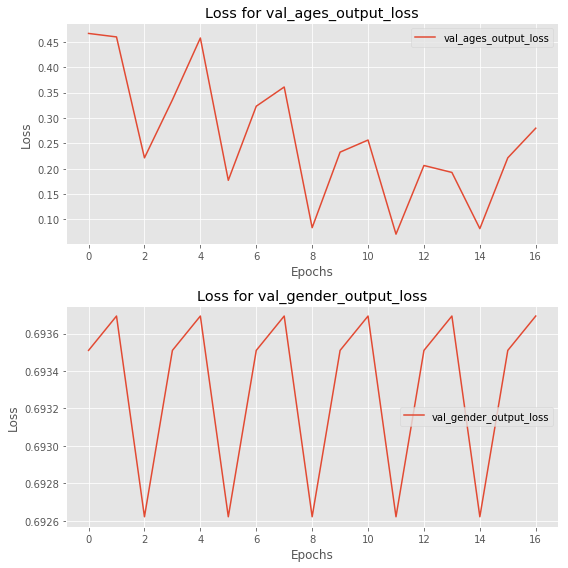

In [46]:
losses = ["val_ages_output_loss", "val_gender_output_loss"]
plt.style.use("ggplot")

(fig, ax) = plt.subplots(2, 1, figsize=(8,8))

for (i, l) in enumerate(losses):
    ax[i].set_title("Loss for {}".format(l))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel("Loss")
  
    ax[i].plot(np.arange(0, REAL_EPOCH), df[l],label=l)
    ax[i].legend()
    
#     ax[0].set_ylim([0,1])
    plt.tight_layout()
    plt.savefig(csv_path+"/val_Xceptionloss1.png")
    

In [47]:
csv_path = "/home/mate/develop/PycharmProjects/GeFace/"
df = pd.read_csv(csv_path+"fine_loss_save.csv")

header = list(df)
REAL_EPOCH = len(df)
REAL_EPOCH

10

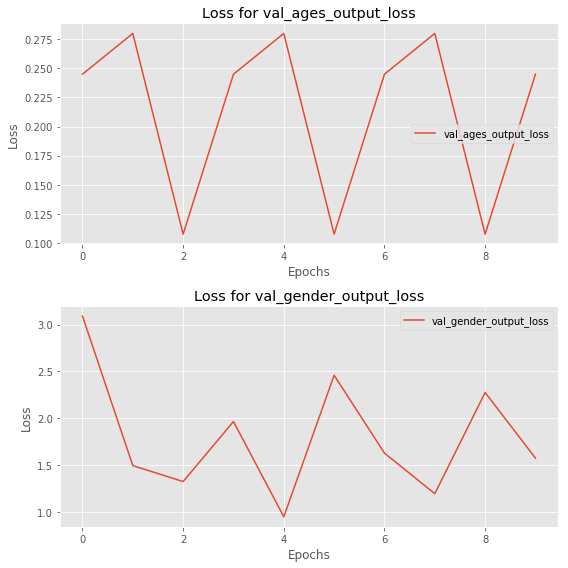

In [49]:
losses = ["val_ages_output_loss", "val_gender_output_loss"]
plt.style.use("ggplot")

(fig, ax) = plt.subplots(2, 1, figsize=(8,8))

for (i, l) in enumerate(losses):
    ax[i].set_title("Loss for {}".format(l))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel("Loss")
  
    ax[i].plot(np.arange(0, REAL_EPOCH), df[l],label=l)
    ax[i].legend()
    
#     ax[0].set_ylim([0,1])
    plt.tight_layout()
    plt.savefig(csv_path+"/val_Xceptionloss.png")
    